<a href="https://colab.research.google.com/github/nikhilv7/My_Wireless_Projects/blob/master/deepMuSiC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The paper: [DeepMUSIC: Multiple Signal Classification via Deep Learning](https://drive.google.com/file/d/1lEqfna5_QjsGqc4QxpvaVpP6qty9l9eR/view?usp=sharing)

Original MuSIC paper: [Multiple Emitter Location and Signal Parameter Estimation](https://drive.google.com/file/d/1B17mGKvs3Tk1yzQbxqmbTH6XNtAZpNhk/view?usp=sharing)

In [1]:
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,BatchNormalization
np.set_printoptions(threshold=10000)

Generation of Training Set

In [2]:
Jalpha=100
Jbeta=100
M=16                #antennaArraySize
targetCount=5
cnnCount=8
gridpoints=2**12
gridperCNN=gridpoints/cnnCount
thetaStart=-60
thetaFinal=60
angRes=(thetaFinal-thetaStart)/gridpoints
subregionWidth=angRes*gridperCNN
thetaValues=np.arange(thetaStart,thetaFinal,angRes)
antennaIndex=np.arange(1,M+1)
pi=np.pi

In [3]:
athetaContinuum=np.exp(-1j*2*np.pi*2*np.outer(antennaIndex-1,np.sin(thetaValues)))
athetaContinuum.shape

(16, 4096)

Randomly selecting 5 angles from different multipaths

In [4]:
thetaSet=np.zeros([Jalpha,targetCount])
for j in range(0,Jalpha):
  theta_Samples=random.sample(list(np.arange(0,8)),k=5)
  for i in range(len(theta_Samples)):
    thetaSet[j,i]= -60 + theta_Samples[i]*subregionWidth + random.choice(list(np.arange(0,512)))*angRes

Generation of a(theta) and Covariance Matrix

In [5]:
def A_matrix(thetaSet1):
  A_mat= np.exp(-1j*2*np.pi*2*np.outer(antennaIndex-1,np.sin(thetaSet1)))
  Ry = A_mat.dot(np.identity(targetCount)).dot(A_mat.conj().T)
  return A_mat, Ry

Eigen Decomposition and Generating the Music Spectra

In [6]:
A,Ry=A_matrix(thetaSet[0,:])
eigenValues, eigenVectors = np.linalg.eig(Ry)
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
NoiseSubspace=eigenVectors[:,targetCount:]
ptheta=np.zeros(gridpoints)
for w in range(gridpoints):
  ptheta[w]=np.divide(1,(athetaContinuum[:,w].conj().T.dot(NoiseSubspace).dot(NoiseSubspace.conj().T).dot(athetaContinuum[:,w])))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


The Functional Model

In [7]:
x_dict={}
out=[]
inputs=K.Input(shape=(M,M,3),name="Ry",dtype=tf.float32)

for i in range(1,cnnCount+1):

  x_dict['x'+str(i)]= layers.Conv2D(256, (5, 5), kernel_initializer='he_normal', activation='relu')(inputs)
  x_dict['x'+str(i)]= layers.BatchNormalization()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.ReLU()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Conv2D(256, (5, 5), kernel_initializer='he_normal', activation='relu')(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.BatchNormalization()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.ReLU()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', activation='relu')(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.BatchNormalization()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.ReLU()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', activation='relu')(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.BatchNormalization()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.ReLU()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Flatten()(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Dense(1024,activation='relu')(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Dropout(0.5)(x_dict['x'+str(i)])
  x_dict['x'+str(i)]= layers.Dense(512,activation='softmax')(x_dict['x'+str(i)])
  x_dict['outputs'+str(i)]= layers.Dense(512)(x_dict['x'+str(i)])
  x_dict["model"+str(i)] = K.Model(inputs=inputs, outputs=x_dict['outputs'+str(i)], name="CNN"+str(i)) 


In [8]:
out=x_dict['outputs'+str(1)]
for i in range(2,cnnCount+1):
  out=tf.concat([out,x_dict['outputs'+str(i)]],1)
out

<tf.Tensor 'concat_6:0' shape=(None, 4096) dtype=float32>

In [9]:
model=K.Model(inputs=inputs, outputs=out, name="CNN"+str(i)) 

Model: "CNN8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Ry (InputLayer)                 [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 12, 12, 256)  19456       Ry[0][0]                         
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 12, 12, 256)  19456       Ry[0][0]                         
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12, 12, 256)  1024        conv2d[0][0]                     
_______________________________________________________________________________________________

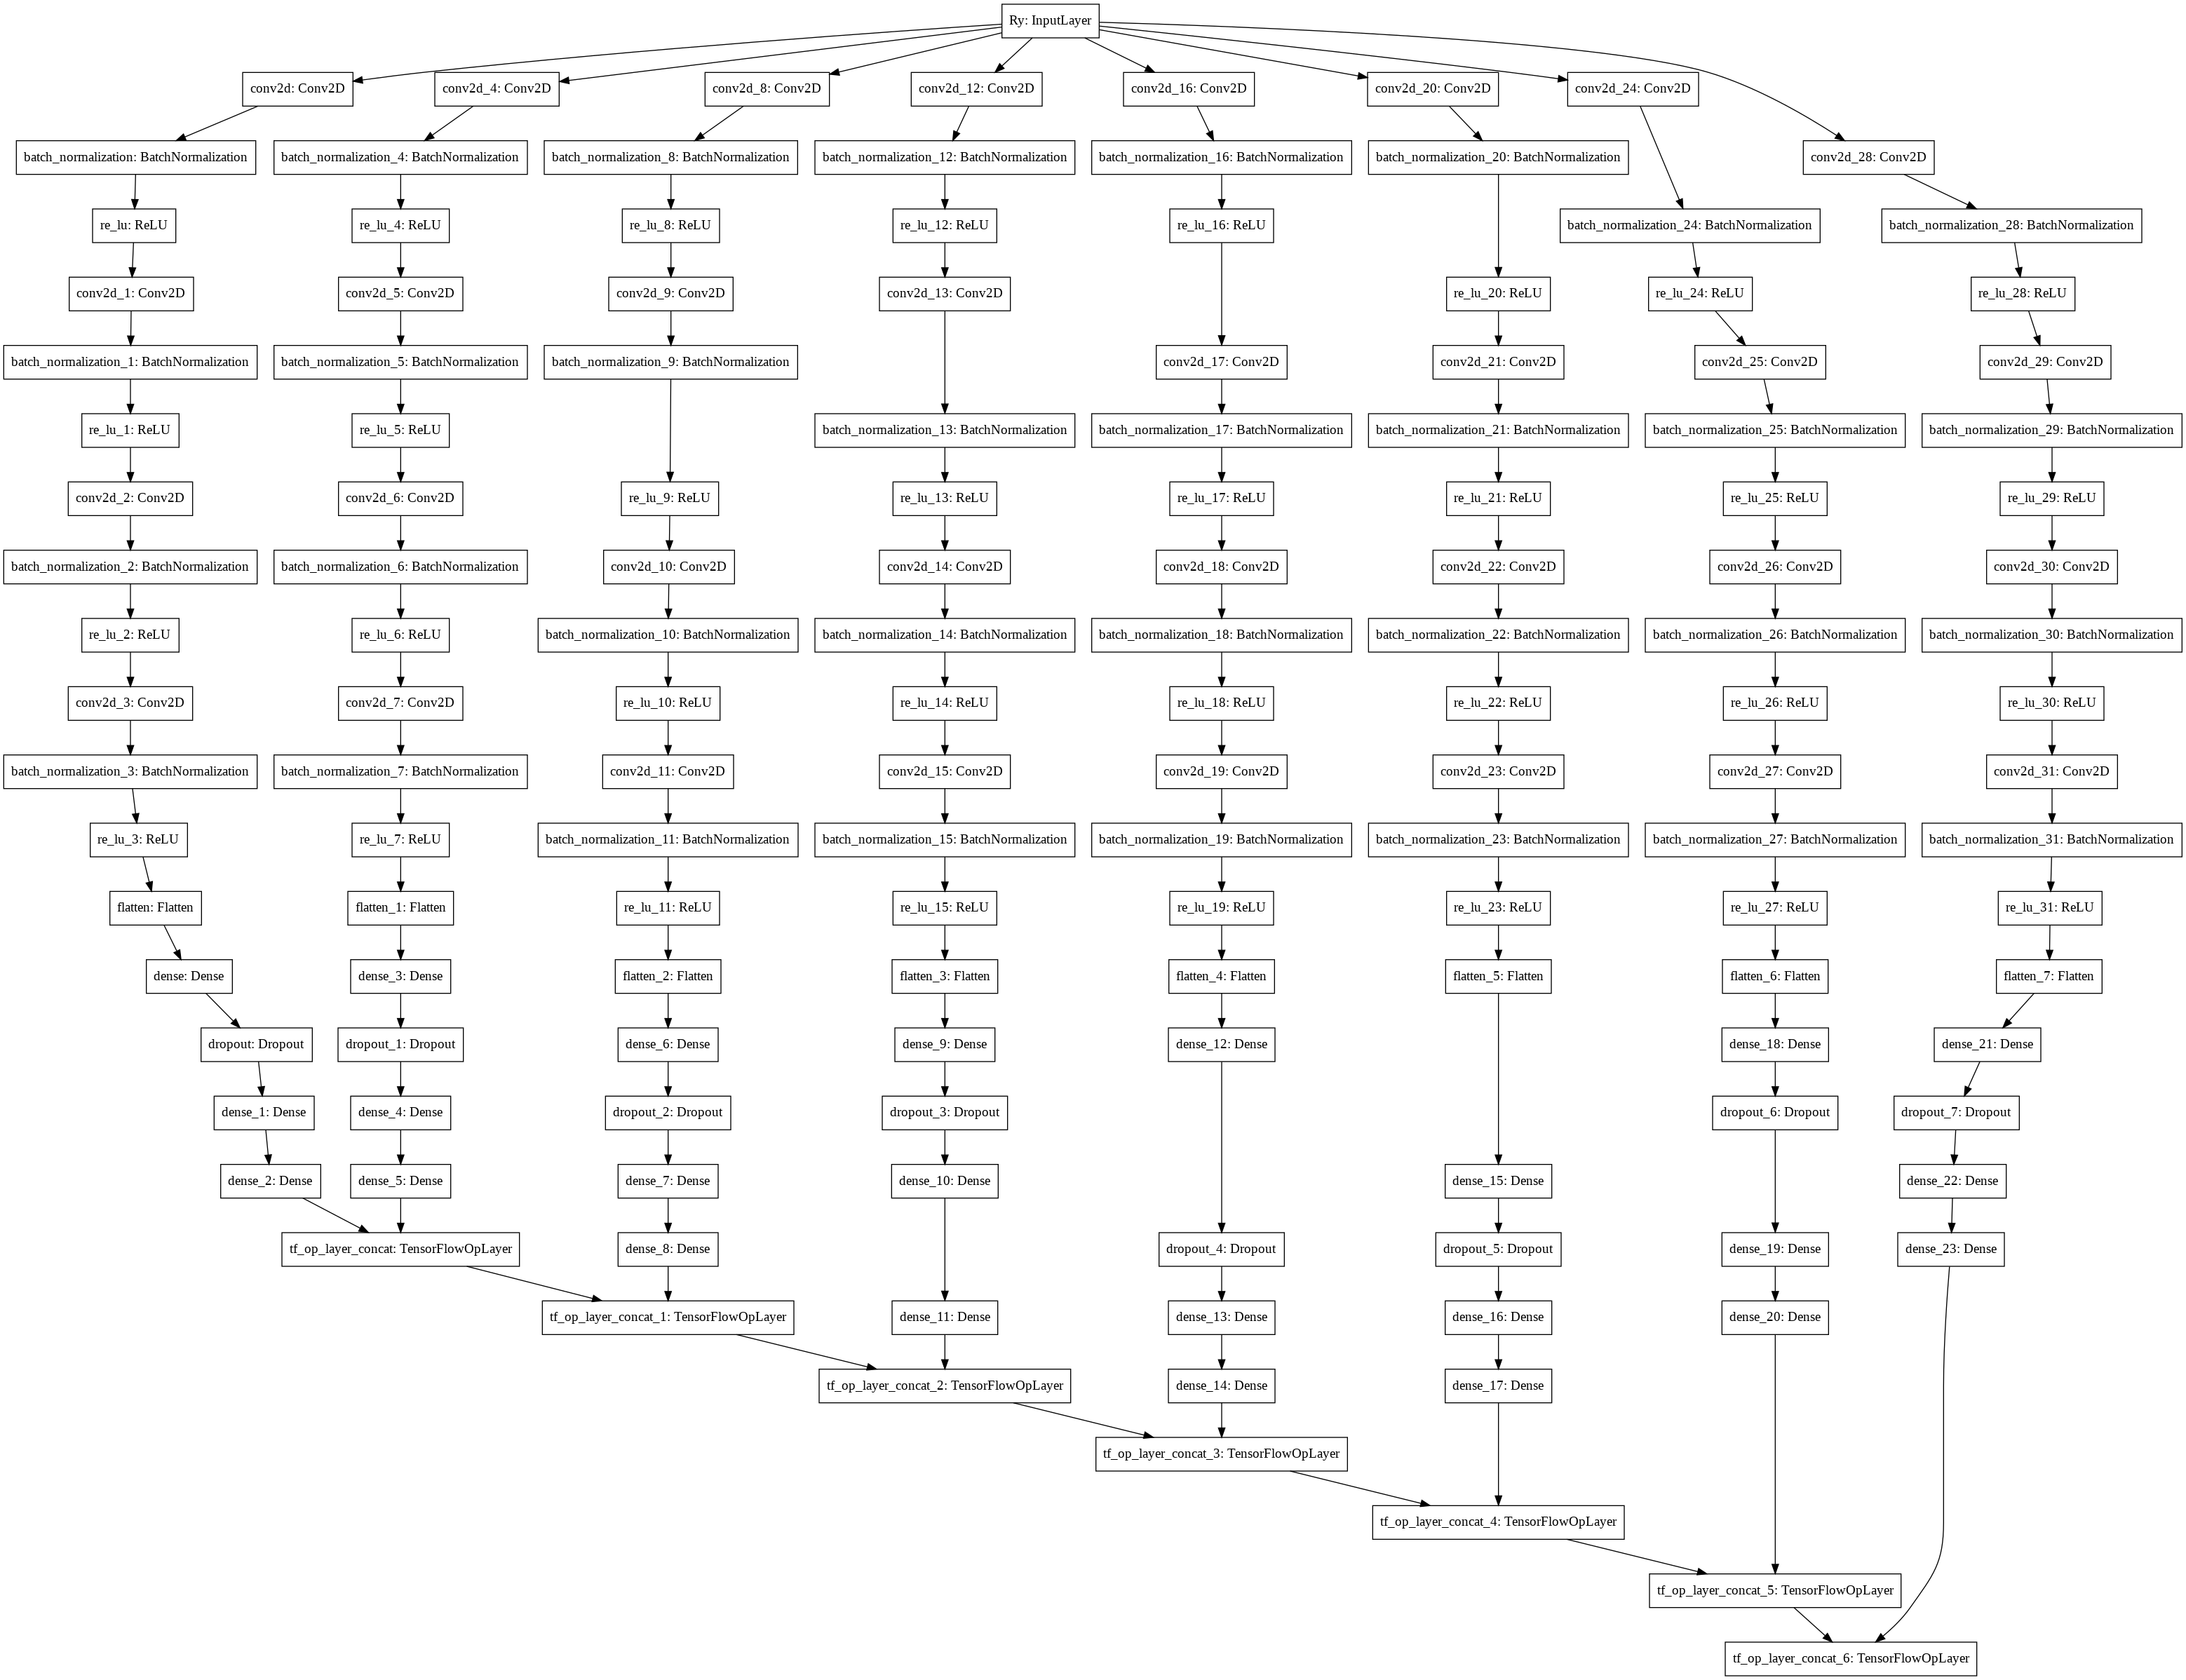

In [12]:
model.summary()
K.utils.plot_model(model, "my_first_model.png")